In [1]:
import numpy as np
rnd = np.random
rnd.seed(0)

In [2]:
k=3 #number of construction sites
f=5 #number of disposal facilities
C_site = [i for i in range(1, k+1)] #construction sites
D_fac = [i for i in range(k+1, k+f+1)] # disposal facilities
V=[0]+C_site+D_fac
Q = {i: rnd.randint(1, 10) for i in C_site} # CDW quantities
F_type=[1,2,3,4] #facilities types
C = {i: 2*i+1 for i in F_type} # treatment costs per unit
P = {i: 2*i+1 for i in F_type} # disposal costs per unit
S = {(i,j): 1000*j for i in D_fac for j in F_type } # building cost of disposal facilities
T = {(i,j): rnd.randint(0,2) for i in C_site for j in F_type}  #  if CDW can be treated by F_type 
B = {(i,j): 1 for i in D_fac for j in F_type }  #ensure that disposal facility type f can be built in candidate location i. 
S_limit= 6000 # upper limit on investment budget
M = 1e10  #big M
T[1,1]=0
T[1,2]=0
T[1,3]=1
T[2,1]=0

In [3]:
# randomly generate the position
loc_x = rnd.rand(len(V))*200 
loc_y = rnd.rand(len(V))*100

(62.49240605225259, 172.2025787386766, 10.38639565153556, 90.6574082255726)

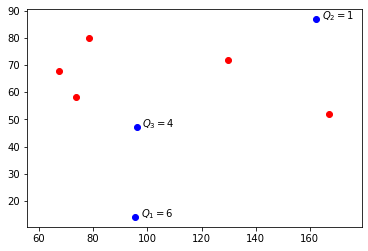

In [4]:
import matplotlib.pyplot as plt
plt.scatter(loc_x[1:k+1], loc_y[1:k+1], c='b')
plt.scatter(loc_x[k+1:k+1+f], loc_y[k+1:k+1+f], c='r')
for i in C_site:
    plt.annotate('$Q_%d=%d$' % (i, Q[i]), (loc_x[i]+2, loc_y[i]))
plt.axis('equal')

In [5]:
A = [(i, j) for i in C_site for j in D_fac]
F = [(i, j) for i in D_fac for j in F_type]

U = [(i, j, k) for i in C_site for j in D_fac for k in F_type]
D = {(i, j): np.hypot(loc_x[i]-loc_x[j], loc_y[i]-loc_y[j]) for i, j in A}

In [6]:
from docplex.mp.model import Model

In [7]:
mdl = Model('CDW')

In [8]:
z = mdl.binary_var_dict(A, name='z')         #(13)

In [9]:
fac = mdl.binary_var_dict(F, name='fac')     #(9)

In [10]:
u = mdl.binary_var_dict(U, name='u')

In [11]:
#Objective
build_cost=mdl.sum(S[i,j]*fac[i,j] for i, j in F )
trans_cost=mdl.sum(Q[i]*D[i, j]*z[i, j]+1 for i, j in A)
disposal_cost = mdl.sum(Q[i]*C[k]*u[i,j,k] for i,j,k in U)
mdl.minimize(build_cost+trans_cost+disposal_cost)
# Constraints
mdl.add_constraints(mdl.sum(fac[i, j] for j in F_type) <= 1 for i in D_fac)                              # (6)
mdl.add_constraints(fac[i,j] <= B[i,j] for i,j in F)                                                     # (7)
mdl.add(mdl.sum(S[i,j]*fac[i,j] for i, j in F ) <= S_limit)                                              # (8)
mdl.add_constraints(mdl.sum(z[i, j] for j in D_fac) == 1 for i in C_site)                                # (11)
mdl.add_constraints(z[i,j] <= mdl.sum(T[i,k]*fac[j,k] for k in F_type) for i in C_site for j in D_fac)   # (12)
mdl.add_constraints(M*(z[i,j_1]-z[i,j_2]-1) <= M*(1-mdl.sum(T[i, k]*fac[j_2, k] for k in F_type)) 
                                                + mdl.sum((D[i,j_2]+P[k])*fac[j_2,k] - (D[i,j_1]+P[k])*fac[j_1,k] for k in F_type) 
                                                for i in C_site for j_1 in D_fac for j_2 in D_fac )      # (15)
mdl.add_constraints(u[i,j,k] >= fac[j,k] + z[i,j]-1 for i,j,k in U)                                      # (19)
mdl.add_constraints(u[i,j,k] >= 0 for i,j,k in U)                                                        # (20)
#Solve
solution = mdl.solve(log_output=True)

Version identifier: 20.1.0.0 | 2020-11-11 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 108 rows and 0 columns.
MIP Presolve modified 1035 coefficients.
Aggregator did 10 substitutions.
Reduced MIP has 121 rows, 85 columns, and 644 nonzeros.
Reduced MIP has 85 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.62 ticks)
Found incumbent of value 7765.969729 after 0.00 sec. (2.54 ticks)
Probing changed sense of 3 constraints.
Probing time = 0.00 sec. (0.21 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 11 rows and 10 columns.
MIP Presolve modified 19 coefficients.
Aggregator did 2 substitutions.
Reduced MIP has 108 rows, 73 columns, and 599 nonzeros.
Reduced MIP has 73 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (1.18 ticks)
Probing time = 0.00 sec. (0.19 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 108 rows, 73 columns, and 599 n

In [12]:
print(solution)

solution for: CDW
objective: 6545.58
z_1_8=1
z_2_5=1
z_3_6=1
fac_5_2=1
fac_6_1=1
fac_8_3=1
u_1_8_3=1
u_2_5_2=1
u_3_6_1=1



In [13]:
solution.solve_status

<JobSolveStatus.OPTIMAL_SOLUTION: 2>

In [14]:
active_arcs = [a for a in A if z[a].solution_value > 0.9]

In [15]:
fac_type = [f for f in F if fac[f].solution_value > 0.9 ]
fac_type

[(5, 2), (6, 1), (8, 3)]

(62.49240605225259, 172.2025787386766, 10.38639565153556, 90.6574082255726)

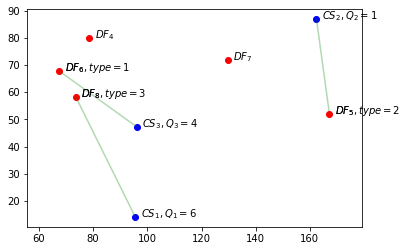

In [16]:
plt.scatter(loc_x[1:k+1], loc_y[1:k+1], c='b')
plt.scatter(loc_x[k+1:k+1+f], loc_y[k+1:k+1+f], c='r')
for i in C_site:
    plt.annotate('$CS_%d,Q_%d=%d$' % (i, i, Q[i]), (loc_x[i]+2, loc_y[i]))
for i in D_fac:
    plt.annotate('$DF_%d$' % (i), (loc_x[i]+2, loc_y[i]))
for i, j in active_arcs:
    plt.plot([loc_x[i], loc_x[j]], [loc_y[i], loc_y[j]], c='g', alpha=0.3)
for i, j in fac_type:
    plt.annotate('$DF_%d,type=%d$' % (i, j), (loc_x[i]+2, loc_y[i]))
plt.axis('equal')